# Anime Recommendation System
In this notebook we will construct a recommendation system using explicit anime rating data collected from multiple users on https://myanimelist.net/. The [dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database#anime.csv) consists of item preference data from 73,516 users on 12,294 different anime TV series / movies / OVAs.

## Index

* [1.0 Data Cleaning and EDA](#1.0-Data-Cleaning-and-EDA)
    * [1.1 Rating Data](#1.1-Rating-Data)
    * [1.2 Anime Data](#1.2-Anime-Data)


    

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1.0 Data Cleaning and EDA
First we'll import our data and familiarize ourselves with it to see if any preprocessing is required. User rating data is stored in `rating.csv`, while item data is stored in `anime.csv`.

### 1.1 Rating Data
The user rating data provided has the following columns:
- `user_id` - non identifiable unique user id.
- `anime_id` - the anime that this user has rated.
- `rating` - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [102]:
# Load user rating data
root = os.getcwd()
user_data_path = os.path.join(root, "data", "rating.csv") 
user_ratings = pd.read_csv(user_data_path)

# Initial inspection
print(user_ratings.dtypes)
user_ratings.head()

user_id     int64
anime_id    int64
rating      int64
dtype: object


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [103]:
# Check missing value counts
pd.isnull(user_ratings).sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [104]:
# Drop duplicate entries
user_ratings.drop_duplicates(subset=['user_id','anime_id'],
                             inplace=True)

user_ratings.reset_index(inplace=True, drop=True)

print(user_ratings.shape)

(7813730, 3)


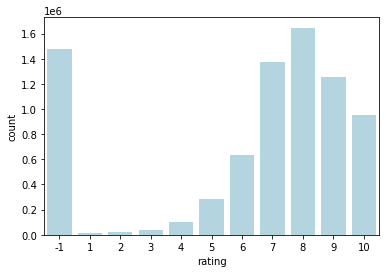

count    7.813730e+06
mean     6.144028e+00
std      3.727801e+00
min     -1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64


In [105]:
# Raw rating distribution
sns.countplot(user_ratings['rating'],
              color='lightblue')
plt.show()
print(user_ratings.describe()['rating'])

Inspecting the initial distribution of ratings indicates that a large proportion of users which marked the anime as 'watched' haven't actually provided a rating (as indicated by the `-1` values). The distribution of provided ratings is left/negatively skewed on a 1-10 integer scale.

This is normal behavior for users and results in a sparse distribution of item ratings. We will relabel all `-1` values to `0`.

In [106]:
# Flag missing ratings with 0
user_ratings.loc[user_ratings['rating'] == -1, 'rating'] = 0

## 1.2 Anime Data
The dataset of anime data is comprised of the following information:

- `anime_id` - myanimelist.net's unique id identifying an anime.
- `name` - full name of anime.
- `genre` - comma separated list of genres for the anime.
- `type` - movie, TV, OVA, etc.
- `episodes` - how many episodes in this show.
- `rating` - average rating out of 10.
- `members` - number of community members that are in this anime's "group".

In [107]:
# Load anime data
anime_data_path = os.path.join(root, "data", "anime.csv") 
anime = pd.read_csv(anime_data_path)

# Initial inspection
print(anime.dtypes)
anime.head()

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [108]:
# Check missing value counts
pd.isnull(anime).sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Since there are missing values in some of the columns, they should be cleaned up if we are going to use them as features. We will create two seperate dataframes for the anime information, one with only average rating info, and the other with all features.

In [123]:
# Index null ratings
idx_null_rating = pd.Index(anime['rating']).isnull()

anime = anime.loc[~idx_null_rating]  # Drop null rows from 'rating'
anime.drop_duplicates(inplace=True)  # Drop duplicates
anime.reset_index(inplace=True, drop=True)

# Ratings only
anime_ratings = anime.drop(columns=['genre','type','episodes','members'])

print(pd.isnull(anime_ratings).sum())
anime_ratings.head()

anime_id    0
name        0
rating      0
dtype: int64


,anime_id,name,rating
0,32281,Kimi no Na wa.,9.37
1,5114,Fullmetal Alchemist: Brotherhood,9.26
2,28977,Gintama°,9.25
3,9253,Steins;Gate,9.17
4,9969,Gintama&#039;,9.16


In [124]:
# Index null genres
idx_null_genre = pd.Index(anime['genre']).isnull()
anime_allfeatures = anime.loc[~idx_null_genre]  # Drop null rows from 'genre'
anime_allfeatures.reset_index(inplace=True, drop=True)

print(pd.isnull(anime_allfeatures).sum())
anime_allfeatures.head()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
